In [1]:
from lsst.resources import ResourcePath
from astropy.io import fits
import os
import numpy
from astropy.table import Table
from dateutil.parser import parse
import re
import json
import matplotlib.pyplot as plt

#MC_C_20240918_000019_R40_SG1_guider.fits
prefix = 'MC_C_'
p = re.compile( rf'{prefix}(\d*)_(\d*)_(R.._S..)_guider.fits' )


In [2]:
def examineone(fname):
    date, seqnum, sensor = p.match(fname).groups()
    path = f's3://embargo@rubin-summit/LSSTCam/{date}/{prefix}{date}_{seqnum}/{fname}'
    rp=ResourcePath(path)
    with rp.open(mode="rb") as f:
        hdu_list = fits.open(f)
    timing = [ parse(hdu.header['STMPTIME']) for hdu in hdu_list[2::2] ]
#    timing = [ parse(hdu.header['STMPTIME']) for hdu in hdu_list[1:] ]    
    mean = [ numpy.mean(hdu.data) for hdu in hdu_list[2::2] ]
    stdnoise = numpy.mean(list(map( lambda x: numpy.std(x.data), hdu_list[2::2]))[1:]) 
    stdstdnoise = numpy.std(list(map( lambda x: numpy.std(x.data), hdu_list[2::2]))[1:]) 
    hz = 1/numpy.mean(numpy.diff(list(map( lambda x: parse(x.header['STMPTIME']), hdu_list[2::2]) )[1:])).total_seconds()
    
    return {
        's3path': rp,
        'basename': rp.abspath().basename(),
        'noise': stdnoise,
        'std(noise)': stdstdnoise,        
        'Hz': hz,
        'mean': mean,
        'timing': timing
    }
    

In [3]:
table=Table(
    list(map( lambda x: examineone(x), [
#        'MC_C_20240918_000019_R00_SG0_guider.fits',        
#        'MC_C_20241004_000117_R00_SG0_guider.fits',
#        'MC_C_20241004_000117_R00_SG1_guider.fits',
#        'MC_C_20241004_000117_R04_SG0_guider.fits',
#        'MC_C_20241004_000117_R04_SG1_guider.fits',
#        'MC_C_20241004_000117_R40_SG0_guider.fits',
#        'MC_C_20241004_000117_R40_SG1_guider.fits',
#        'MC_C_20241004_000117_R44_SG0_guider.fits',
#        'MC_C_20241004_000117_R44_SG1_guider.fits'
         'MC_C_20241008_000025_R00_SG0_guider.fits',
         'MC_C_20241008_000025_R00_SG1_guider.fits'
    ])
       )
)
table['basename','noise','std(noise)','Hz','mean','timing']

basename,noise,std(noise),Hz,mean,timing
str40,float64,float64,float64,float64[131],object[131]
MC_C_20241008_000025_R00_SG0_guider.fits,2903.1836209272233,7210.806491067357,9.16514677982568,13024.388 .. 13023.726,2024-10-08 14:38:09.778000 .. 2024-10-08 14:38:24.641000
MC_C_20241008_000025_R00_SG1_guider.fits,2610.9252217231647,6493.325100551507,9.16514677982568,13207.5408 .. 13205.876,2024-10-08 14:38:09.778000 .. 2024-10-08 14:38:24.641000


In [4]:
table

s3path,basename,noise,std(noise),Hz,mean,timing
object,str40,float64,float64,float64,float64[131],object[131]
s3://embargo@rubin-summit/LSSTCam/20241008/MC_C_20241008_000025/MC_C_20241008_000025_R00_SG0_guider.fits,MC_C_20241008_000025_R00_SG0_guider.fits,2903.1836209272233,7210.806491067357,9.16514677982568,13024.388 .. 13023.726,2024-10-08 14:38:09.778000 .. 2024-10-08 14:38:24.641000
s3://embargo@rubin-summit/LSSTCam/20241008/MC_C_20241008_000025/MC_C_20241008_000025_R00_SG1_guider.fits,MC_C_20241008_000025_R00_SG1_guider.fits,2610.9252217231647,6493.325100551507,9.16514677982568,13207.5408 .. 13205.876,2024-10-08 14:38:09.778000 .. 2024-10-08 14:38:24.641000


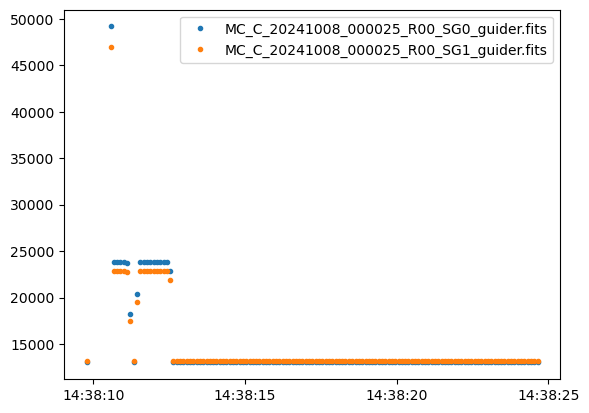

In [16]:
for row in table:
    plt.plot(row['timing'],row['mean'],'.',label=row['basename'])
plt.legend()

In [17]:
rp = ResourcePath(table[1]['s3path'].geturl().replace('.fits','.json'))
with rp.open(mode="r") as f:
    j=json.load(f)
print(json.dumps(j,indent=2))

{
  "__CONTENT__": "metadata",
  "SIMPLE": true,
  "BITPIX": 8,
  "NAXIS": 0,
  "EXTEND": true,
  "BINX": 1,
  "BINY": 1,
  "CCDGAIN": 1.0,
  "CCDNOISE": 10.0,
  "DETSIZE": "[1:4072,1:4000]",
  "DATE": "2024-10-08T14:38:09.843",
  "MJD": 60591.60983614577,
  "IMGTYPE": "UNKNOWN",
  "OBSID": "MC_C_20241008_000025",
  "BUNIT": "adu",
  "TIMESYS": "TAI",
  "INSTRUME": "lsstCam",
  "TELESCOP": "Simonyi Survey Telescope",
  "OBS-LONG": null,
  "OBS-LAT": null,
  "OBS-ELEV": null,
  "OBSGEO-X": null,
  "OBSGEO-Y": null,
  "OBSGEO-Z": null,
  "RA": null,
  "DEC": null,
  "RASTART": null,
  "DECSTART": null,
  "RAEND": null,
  "DECEND": null,
  "ROTPA": null,
  "ROTCOORD": null,
  "HASTART": null,
  "ELSTART": null,
  "AZSTART": null,
  "AMSTART": null,
  "HAEND": null,
  "ELEND": null,
  "AZEND": null,
  "AMEND": null,
  "TRACKSYS": null,
  "RADESYS": null,
  "FOCUSZ": null,
  "OBJECT": null,
  "VIGNETTE": null,
  "VIGN_MIN": null,
  "CAMCODE": "MC",
  "CONTRLLR": "C",
  "DAYOBS": "20241008",

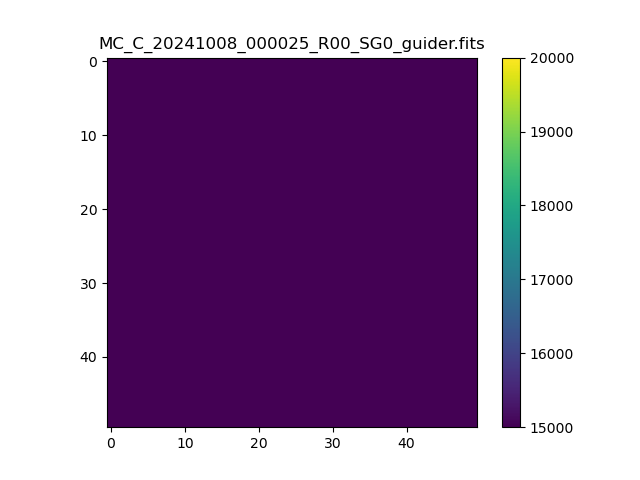

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from astropy.io import fits
from IPython.display import HTML
%matplotlib widget

with table[0]['s3path'].open(mode='rb') as f:
    fh = fits.open(f)

fig, ax = plt.subplots()

frames = [[plt.imshow(img.data, vmin=15000,vmax=20000,animated=True)] for img in fh[2::2]]
plt.colorbar()
plt.title(table[0]['basename'])
ani = animation.ArtistAnimation(fig, frames, interval=120, blit=True, repeat_delay=1000)

HTML(ani.to_html5_video())
#plt.show()

In [7]:
fname = 'MC_C_20241005_000148_R04_SG1_guider.fits'
date, seqnum, sensor = p.match(fname).groups()
path = f's3://embargo@rubin-summit/LSSTCam/{date}/{prefix}{date}_{seqnum}/{fname}'
rp=ResourcePath(path)
with rp.open(mode="rb") as f:
    hdu_list = fits.open(f)